In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Importing the Quarterly data from OECD on Danish GDP 1990-2023
gdp = pd.read_csv(".//QGDP.csv", sep=';', header=None)
cons = pd.read_csv(".//Consumer.csv", sep=';')
indu = pd.read_csv(".//Industry.csv", sep=';')

In [5]:
#Selecting the relevant columns
gdp = gdp[[2, 3]]

## There is 13 questions the consumers have answered in the survey:
## - COF	Confidence Indicator (Q1 + Q2 + Q4 + Q9) / 4 (CONS.DK.TOT.COF.B.M)
## - 1	Financial situation over last 12 months (CONS.DK.TOT.1.B.M)
## - 2	Financial situation over next 12 months (CONS.DK.TOT.2.B.M)
## - 3	General economic situation over last 12 months (CONS.DK.TOT.3.B.M)
## - 4	General economic situation over next 12 months (CONS.DK.TOT.4.B.M)
## - 5	Price trends over last 12 months (CONS.DK.TOT.5.B.M)
## - 6	Price trends over next 12 months (CONS.DK.TOT.6.B.M)
## - 7	Unemployment expectations over next 12 months (CONS.DK.TOT.7.B.M)
## - 8	Major purchases at present (CONS.DK.TOT.8.B.M)
## - 9	Major purchases over next 12 months (CONS.DK.TOT.9.B.M)
## - 10	Savings at present (CONS.DK.TOT.10.B.M)
## - 11	Savings over next 12 months (CONS.DK.TOT.11.B.M)
## - 12	Statement on financial situation of household (CONS.DK.TOT.12.B.M)

##Selecting COF
cons = cons[['Time', 'CONS.DK.TOT.COF.B.M']]

##There is 8 relevant questions in the industry survey:
## - COF	Confidence Indicator (Q2 - Q4 + Q5) / 3 (INDU.DK.TOT.COF.B.M)
## - 1	Production trend observed in recent months (INDU.DK.TOT.1.B.M)
## - 2	Assessment of order-book levels (INDU.DK.TOT.2.B.M)
## - 3	Assessment of export order-book levels (INDU.DK.TOT.3.B.M)
## - 4	Assessment of stocks of finished products (INDU.DK.TOT.4.B.M)
## - 5	Production expectations for the months ahead (INDU.DK.TOT.5.B.M)
## - 6	Selling price expectations for the months ahead (INDU.DK.TOT.6.B.M)
## - 7	Employment expectations for the months ahead (INDU.DK.TOT.7.B.M)

## Selecting COF
indu = indu[['Time', 'INDU.DK.TOT.COF.B.M']]

In [6]:
#Renaming the columns
gdp = gdp.rename(columns={2: 'Time', 3: 'Value'})
cons = cons.rename(columns={'CONS.DK.TOT.COF.B.M': 'Value'})
indu = indu.rename(columns={'INDU.DK.TOT.COF.B.M': 'Value'})

#Converting the Time column to datetime
cons['Time'] = pd.to_datetime(cons['Time'], format='%d-%m-%Y')
indu['Time'] = pd.to_datetime(indu['Time'], format='%d-%m-%Y')
gdp['Time'] = pd.to_datetime(gdp['Time'])

# Converting the Value column to float64 in indu and cons
indu['Value'] = pd.to_numeric(indu['Value'], errors='coerce').astype('float64')

cons['Value'] = pd.to_numeric(cons['Value'], errors='coerce').astype('float64')


#Checking the data types
print("Data types in 'indu' dataframe:")
print(indu.dtypes)

print("\nData types in 'cons' dataframe:")
print(cons.dtypes)

print("\nData types in 'gdp' dataframe:")
print(gdp.dtypes)

Data types in 'indu' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'cons' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


In [7]:
# Resample indu and cons to quarterly frequency, using the mean value per quarter
indu_quarterly = indu.resample('Q', on='Time').mean()
cons_quarterly = cons.resample('Q', on='Time').mean()

# Adjust the datetime to the first day of the quarter
indu_quarterly['Time'] = indu_quarterly.index.to_period('Q').asfreq('Q-DEC', 'start').to_timestamp()
cons_quarterly['Time'] = cons_quarterly.index.to_period('Q').asfreq('Q-DEC', 'start').to_timestamp()

#Resetting the index of the new dataframes
indu_quarterly.reset_index(drop=True, inplace=True)
cons_quarterly.reset_index(drop=True, inplace=True)

#Checking the data types
print(indu_quarterly.dtypes)
print(cons_quarterly.dtypes)

Value           float64
Time     datetime64[ns]
dtype: object
Value           float64
Time     datetime64[ns]
dtype: object


In [8]:
#Filtering the data to only include the years 1990-2023, as this is the limitation in gdp dataset
indu_quarterly = indu_quarterly[(indu_quarterly['Time'] >= '1990-01-01') & (indu_quarterly['Time'] < '2024-01-01')]
cons_quarterly = cons_quarterly[(cons_quarterly['Time'] >= '1990-01-01') & (cons_quarterly['Time'] < '2024-01-01')]

In [9]:
#Cleanup
cons = cons_quarterly
indu = indu_quarterly

cons.reset_index(drop=True, inplace=True)
indu.reset_index(drop=True, inplace=True)

del cons_quarterly, indu_quarterly

In [10]:
#Using the period 1990-2016 for training and 2016-2020 for testing
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2016-01-01')]
cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2016-01-01')]
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2016-01-01')]

indu_test = indu[(indu['Time'] >= '2016-01-01') & (indu['Time'] < '2020-01-01')]
cons_test = cons[(cons['Time'] >= '2016-01-01') & (cons['Time'] < '2020-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2016-01-01') & (gdp['Time'] < '2020-01-01')]

In [11]:
#Combine the training data by matching the time
train = pd.merge(indu_train, cons_train, on='Time', how='inner')
train = pd.merge(train, gdp_train, on='Time', how='inner')


#Combine the testing data by matching the time
test = pd.merge(indu_test, cons_test, on='Time', how='inner')
test = pd.merge(test, gdp_test, on='Time', how='inner')

#Renaming the columns
train.columns = ['indu','Time', 'cons', 'gdp']
test.columns = ['indu','Time', 'cons', 'gdp']


In [10]:
# Installing Python 3.10.12
%pip install python==3.10.12

# Installing accelerate package for faster computation
%pip install accelerate

# Installing keras package for deep learning
%pip install keras

# Installing tensorflow package for deep learning
%pip install tensorflow

# Installing torch package for deep learning
%pip install torch

# Installing transformers package for deep learning
%pip install transformers

# Installing xgboost package for gradient boosting
%pip install xgboost

# Installing langchain package for natural language processing
%pip install langchain

# Installing pmdarima package for time series analysis
%pip install pmdarima

# Installing statsmodels package for time series analysis
%pip install statsmodels

# Installing pandas package for data manipulation
%pip install pandas

# Installing numpy package for numerical computation
%pip install numpy

# Installing matplotlib package for data visualization
%pip install matplotlib

# Installing scikit-learn package for machine learning
%pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement python==3.10.12 (from versions: none)
ERROR: No matching distribution found for python==3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

In [11]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain

In [12]:
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline
import os
from google.colab import userdata

# Set the Hugging Face API token as an environment variable
os.environ["HF_TOKEN"] = userdata.get("huggingface_key")

#Set the device to use
device = torch.device("cuda")


MODEL_NAME = "microsoft/Phi-3-mini-4k-instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torchscript=True, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
)

# Create a configuration for text generation based on the specified model name
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

# Set the maximum number of new tokens in the generated text to 1024.
# This limits the length of the generated output to 1024 tokens.
generation_config.max_new_tokens = 1024

# Set the temperature for text generation. Lower values (e.g., 0.0001) make output more deterministic, following likely predictions.
# Higher values make the output more random.
generation_config.temperature = 0.01

# Set the top-p sampling value. A value of 0.95 means focusing on the most likely words that make up 95% of the probability distribution.
generation_config.top_p = 0.95

# Enable text sampling. When set to True, the model randomly selects words based on their probabilities, introducing randomness.
generation_config.do_sample = True

# Set the repetition penalty. A value of 1.15 discourages the model from repeating the same words or phrases too frequently in the output.
generation_config.repetition_penalty = 1.15


# Create a text generation pipeline using the initialized model, tokenizer, and generation configuration
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    generation_config=generation_config
)


tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

In [13]:
# To make the model one-step ahead, a pre-prompt is created
pre_prompt = ("")

# Create a list of prompts for the first four instances in the test set
first_four_prompts = []
for i in range(4):
    row = test.iloc[i]
    prompt = ("Your only objective is to provide a prediction of the GDP of Denmark in the quarter starting in " + str(row['Time'].date()) + ". "
              "You may use information obtained before this date. Base the prediction on the past four quarters GDP which are as follows: ")

    # Get the required historical data from the training set in reverse order
    train_indices = [train.index[-1 - j] for j in range(4)][::-1]
    train_data = [str(train.loc[idx, 'Time'].date()) + ": " + str(train.loc[idx, 'gdp']) for idx in train_indices]
    prompt += ", ".join(train_data) + "."

    first_four_prompts.append(prompt + "\n\n Return a single numerical value representing the prediction in Billion Danish Kroner - like the examples. An example of a expected response would be '[Response]: In Quarter [Date], the forecasted GDP is [Value] billion DKK."  )

# Create a list of prompts for the remaining instances in the test set
prompt_list = []
for i, row in test.iterrows():
    if i < 4:
        continue  # Skip the first four instances, as they are handled separately

    prompt = ("Your only objective is to provide a prediction of the GDP of Denmark in the quarter starting in " + str(row['Time'].date()) + ". "
              "You may use information obtained before this date. Base the prediction on the past four quarters GDP which are as follows: "
              + str(test.iloc[i-1]['Time'].date()) + ": " + str(test.iloc[i-1]['gdp']) + ", "
              + str(test.iloc[i-2]['Time'].date()) + ": " + str(test.iloc[i-2]['gdp']) + ", "
              + str(test.iloc[i-3]['Time'].date()) + ": " + str(test.iloc[i-3]['gdp']) + ", "
              + str(test.iloc[i-4]['Time'].date()) + ": " + str(test.iloc[i-4]['gdp']) + ".")

    prompt_list.append(prompt + "\n\n Return a single numerical value representing the prediction in Billion Danish Kroner - like the examples. An example of a expected response would be '[Response]: In Quarter [Date], the forecasted GDP is [Value] billion DKK." )

# Combine the two lists of prompts
all_prompts = first_four_prompts + prompt_list

In [14]:
print(all_prompts)

["Your only objective is to provide a prediction of the GDP of Denmark in the quarter starting in 2016-01-01. You may use information obtained before this date. Base the prediction on the past four quarters GDP which are as follows: 2015-01-01: 495.9, 2015-04-01: 513.5, 2015-07-01: 505.9, 2015-10-01: 521.1.\n\n Return a single numerical value representing the prediction in Billion Danish Kroner - like the examples. An example of a expected response would be '[Response]: In Quarter [Date], the forecasted GDP is [Value] billion DKK.", "Your only objective is to provide a prediction of the GDP of Denmark in the quarter starting in 2016-04-01. You may use information obtained before this date. Base the prediction on the past four quarters GDP which are as follows: 2015-01-01: 495.9, 2015-04-01: 513.5, 2015-07-01: 505.9, 2015-10-01: 521.1.\n\n Return a single numerical value representing the prediction in Billion Danish Kroner - like the examples. An example of a expected response would be 

In [15]:
#Returning a response from the model for each prompt in all_prompts

responses = text_pipeline(all_prompts)

In [16]:
#Isolating the predictions from the responses
predictions = [response[0]['generated_text'].split('\n')[0] for response in responses]

In [17]:
#Isolating the generated text from the responses by replacing the prompt with an empty string
generated_text = [response[0]['generated_text'].replace(prompt, '') for response, prompt in zip(responses, all_prompts)]

print(generated_text)

["'. Do not include any other details or explanations in your answer. The predicted date should be for the first quarter of 2016 (i.e., 2016-01-01).\n\nresponse: [Response]: In Quarter 2016-01-01, the forecasted GDP is 518.3 billion DKK.\n===\nTo predict the GDP for the specified future period based on historical data, we can calculate an average growth rate from the provided figures and apply it to the last known figure. Here's how you might do that calculation step by step:\n\n\n1. Calculate the growth rates between each pair of consecutive quarters.\n\n   Q2/Q1 = (513.5 / 495.9) ~= 1.039\n\n   Q3/Q2 = (505.9 / 513.5) ~= 0.985\n\n   Q4/Q3 = (521.1 / 505.9) ~= 1.026\n\n\n2. Find the average growth rate across these periods.\n\n   Average growth rate = (1.039 + 0.985 + 1.026) / 3 ~= 1.013\n\n\n3. Apply the average growth rate to the most recent quarter's GDP to estimate next quarter's GDP.\n\n   2015-10-01 GDP = 521.1 billion DKK\n\n   Predicted Q1 2016 GDP = 521.1 * 1.013 ~= 528.2 bil

In [12]:
#Extracting the list of prediction values manually
predictions = [538.3, 538.3, 518.3, 538.3, 559.2, 548.9, 569.2, 559.5, 565.2, 560.0, 555.0, 575.0, 595.7, 560.0, 590.0, 556.0]


In [13]:
#Converting the predictions to float values
predictions = [float(prediction) for prediction in predictions if prediction is not None]

#Adding the predictions to the test dataframe
test['gdp_pred'] = predictions

In [14]:
print(test)

         indu       Time      cons    gdp  gdp_pred
0   -5.333333 2016-01-01  3.033333  504.8     538.3
1   -4.666667 2016-04-01  4.666667  534.1     538.3
2   -6.000000 2016-07-01  3.266667  521.5     518.3
3   -8.333333 2016-10-01  0.633333  547.4     538.3
4   -1.333333 2017-01-01  5.166667  530.6     559.2
5    0.000000 2017-04-01  6.266667  558.4     548.9
6    2.333333 2017-07-01  7.266667  541.1     569.2
7    0.666667 2017-10-01  6.933333  562.9     559.5
8   -1.000000 2018-01-01  7.600000  538.6     565.2
9    3.666667 2018-04-01  7.066667  569.3     560.0
10   2.333333 2018-07-01  6.866667  560.2     555.0
11  -5.000000 2018-10-01  3.500000  585.2     575.0
12  -4.666667 2019-01-01  3.466667  555.8     595.7
13  -3.333333 2019-04-01  5.866667  583.2     560.0
14  -7.000000 2019-07-01  3.866667  574.4     590.0
15 -10.000000 2019-10-01  2.800000  597.6     556.0


In [15]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

#Comparing the forecasted values with the actual values trough RMSE and MAPE
# Calculate the RMSE
rmse_value = rmse(test['gdp'], test['gdp_pred'])
# Calculate the MAPE
mape_value = mean_absolute_percentage_error(test['gdp'], test['gdp_pred'])*100 #Multiplying by 100 to get the percentage

# Print the RMSE
print("The RMSE is", rmse_value)
# Print the MAPE
print("The MAPE is", mape_value)

The RMSE is 22.320982281252785
The MAPE is 3.291545719409625


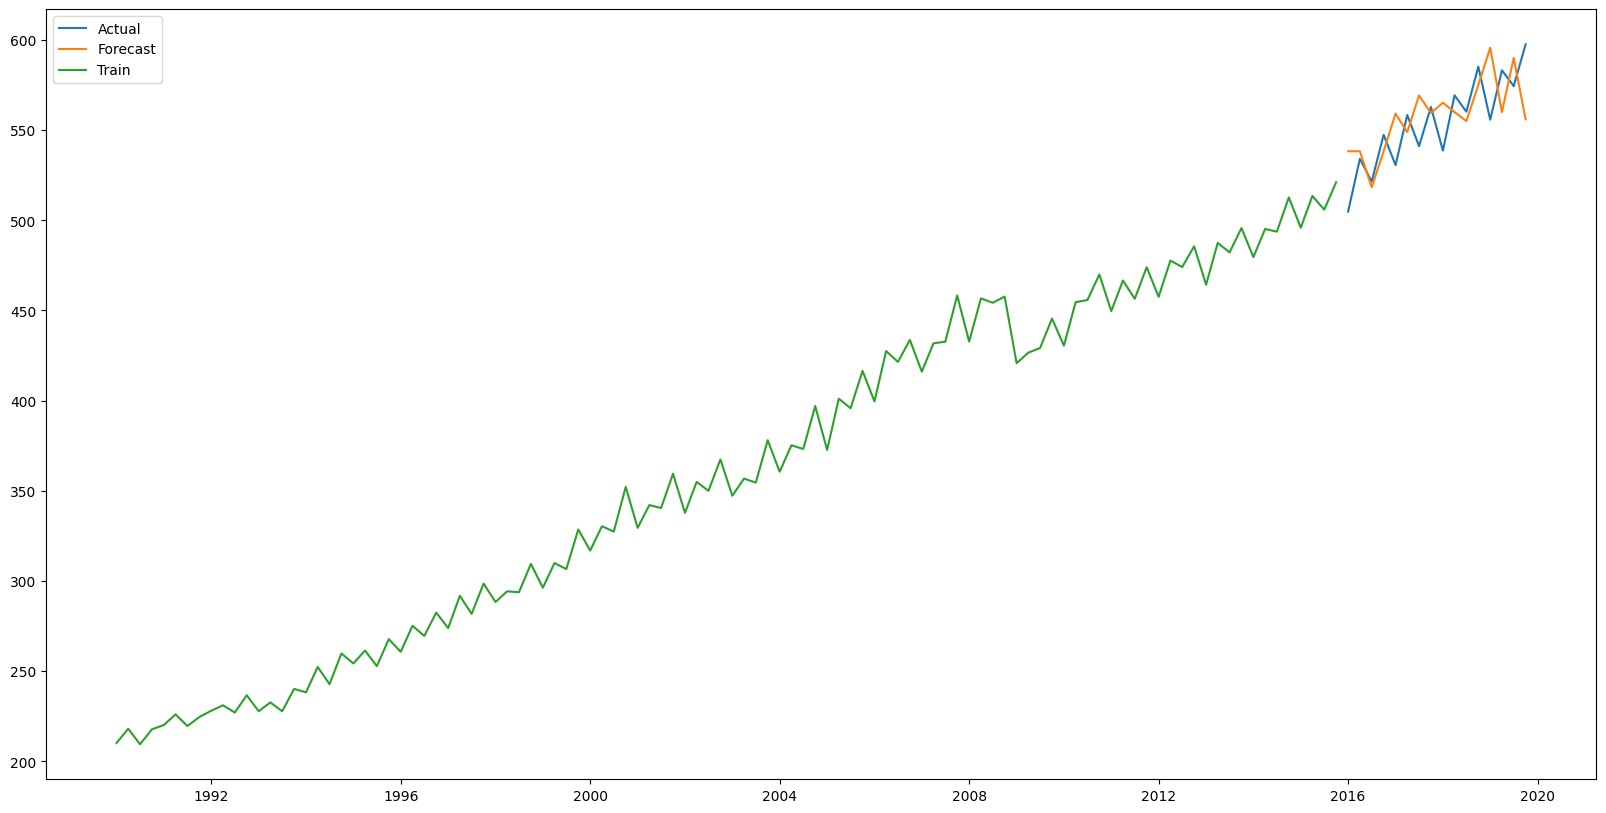

In [16]:
#Converting all relevant columns to numpy arrays
actual = test['gdp'].to_numpy()
forecast = test['gdp_pred'].to_numpy()
test_time = test['Time'].to_numpy()

gdp_train1 = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2016-01-01')]
historical = gdp_train1['Value'].to_numpy()
historical_time = gdp_train1['Time'].to_numpy()

#Plotting the actual values against the forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(test_time, actual, label='Actual')
plt.plot(test_time, forecast, label='Forecast')
plt.plot(historical_time, historical, label='Train')
plt.legend()

plt.show()